In [417]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [418]:
cd '/content/drive/MyDrive/noi_hack'

/content/drive/MyDrive/noi_hack


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

In [134]:
def add_gaussian_noise(data, noise_std):
    noise = torch.randn_like(data) * noise_std
    return data + noise

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
f_l = ["datasets/ext_1.csv", "datasets/ext_2.csv", "datasets/ext_3.csv", "datasets/ext_4.csv", "datasets/ext_5.csv"]
timeseries = []
for f in f_l:
    # Read the CSV file
    df = pd.read_csv(f)

    # Convert the "Date and time" column to datetime
    df['Date and time'] = pd.to_datetime(df['Date and time'])

    # Extract the date and time components
    df['Date'] = df['Date and time'].dt.date

    # Group by the date
    grouped = df.groupby('Date')

    # Prepare a list to collect valid days data
    valid_days = []

    # Iterate over each group
    for date, group in grouped:
        if len(group) == 96:
            valid_days.append(group['External temperature (Celsius degree)'].values)

    # Convert the list of valid days to a numpy array (tensor)
    timeseries.append(torch.tensor(np.array(valid_days)))

In [16]:
all_timeseries = torch.cat(timeseries, dim=0)

In [17]:
all_timeseries.shape

torch.Size([1521, 96])

In [18]:
daily_avg_temp = torch.mean(all_timeseries, dim=1, keepdim=True)

In [19]:
daily_avg_temp.shape

torch.Size([1521, 1])

In [20]:
avg_temps = daily_avg_temp.float()
timeseries = all_timeseries.float()

In [372]:
# Hyperparameters
noise_dim = 64  # Latent vector size
hidden_dim = 256  # Size of hidden layers
output_dim = 96  # Number of 15-minute intervals in a day

# Learning rates and training parameters
lr = 1e-5
batch_size = 32
num_epochs = 150

In [373]:
dataset = TensorDataset(daily_avg_temp, all_timeseries)

train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [374]:
class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + 1, hidden_dim),  # noise_dim + 1 for avg_temp
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, output_dim)  # Output 96 values
        )

    def forward(self, noise, avg_temp):
        avg_temp = avg_temp.view(-1, 1)  # Ensure avg_temp is the right shape
        x = torch.cat((noise, avg_temp), dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # input_dim + 1 for avg_temp
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim*2, output_dim),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, timeseries, avg_temp):
        avg_temp = avg_temp.view(-1, 1)  # Ensure avg_temp is the right shape
        x = torch.cat((timeseries, avg_temp), dim=1)
        return self.model(x)

In [375]:
class TemporalLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(TemporalLoss, self).__init__()
        self.alpha = alpha

    def forward(self, generated_sequence):
        # Calculate the difference between consecutive time steps
        diff = torch.abs(generated_sequence[:, 1:] - generated_sequence[:, :-1])
        # Sum of all differences in the batch
        loss = diff.sum()
        # Combine with a weight factor alpha
        return self.alpha * loss

In [376]:
class MeanLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(MeanLoss, self).__init__()
        self.alpha = alpha

    def forward(self, generated_sequence, real_mean):
        mean_gen = torch.mean(generated_sequence, dim=1, keepdim=True)


        diff = mean_gen - real_mean
        squared_diff = diff ** 2
        mse = torch.mean(squared_diff)

        return self.alpha * mse

In [377]:

# Initialize models
generator = Generator(noise_dim, hidden_dim, output_dim).to(device)
discriminator = Discriminator(output_dim, hidden_dim, 1).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr*2, weight_decay=1e-5)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr*0.55, weight_decay=1e-5)

# Loss function
criterion = nn.BCELoss()

temporal_loss_fn = TemporalLoss(alpha=0.0001)
mean_loss_fn = MeanLoss(alpha=0.005)

In [378]:
# Training loop with validation
for epoch in range(num_epochs):
    # Training phase
    generator.train()
    discriminator.train()
    for i, (avg_temp, real_timeseries) in enumerate(train_loader):

        batch_size = avg_temp.size(0)

        # Move data to device and ensure float32 type
        avg_temp = avg_temp.to(device).float()
        real_timeseries = real_timeseries.to(device).float()
        real_timeseries = add_gaussian_noise(real_timeseries, 0.3)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=device).float()
        fake_labels = torch.zeros(batch_size, 1, device=device).float()

        # Train Discriminator
        optimizer_d.zero_grad()

        # Real timeseries
        real_output = discriminator(real_timeseries, avg_temp)
        d_loss_real = criterion(real_output, real_labels)

        # Fake timeseries
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_timeseries = generator(noise, avg_temp)
        fake_output = discriminator(fake_timeseries, avg_temp)
        d_loss_fake = criterion(fake_output, fake_labels)

        #temporal_loss = temporal_loss_fn(fake_timeseries)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake# + temporal_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_timeseries = generator(noise, avg_temp)
        fake_output = discriminator(fake_timeseries, avg_temp)

        # Generator loss
        g_loss = criterion(fake_output, real_labels)

        temporal_loss = temporal_loss_fn(fake_timeseries)
        mean_loss = mean_loss_fn(fake_timeseries, avg_temp)

        total_g_loss = g_loss + temporal_loss + mean_loss

        total_g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')



Epoch [1/150], d_loss: 1.0029218196868896, g_loss: 0.6826080083847046
Epoch [2/150], d_loss: 0.8396947383880615, g_loss: 0.7124549150466919
Epoch [3/150], d_loss: 0.7384053468704224, g_loss: 0.7390857934951782
Epoch [4/150], d_loss: 0.9466662406921387, g_loss: 0.5905693769454956
Epoch [5/150], d_loss: 1.0934672355651855, g_loss: 0.6618783473968506
Epoch [6/150], d_loss: 1.5145666599273682, g_loss: 0.6368563175201416
Epoch [7/150], d_loss: 1.536868691444397, g_loss: 0.6543986201286316
Epoch [8/150], d_loss: 1.3319623470306396, g_loss: 0.7602350115776062
Epoch [9/150], d_loss: 1.4053869247436523, g_loss: 0.72013920545578
Epoch [10/150], d_loss: 1.4252893924713135, g_loss: 0.6879916191101074
Epoch [11/150], d_loss: 1.4020675420761108, g_loss: 0.6996550559997559
Epoch [12/150], d_loss: 1.331667184829712, g_loss: 0.72878098487854
Epoch [13/150], d_loss: 1.3408253192901611, g_loss: 0.7209950685501099
Epoch [14/150], d_loss: 1.369598388671875, g_loss: 0.7087389230728149
Epoch [15/150], d_loss

In [393]:
# Validation phase
generator.eval()
discriminator.eval()
val_d_loss = 0
val_g_loss = 0

residuals = []

with torch.no_grad():
    for avg_temp, real_timeseries in val_loader:
        batch_size = avg_temp.size(0)

        # Move data to device
        # Move data to device and ensure float32 type
        avg_temp = avg_temp.to(device).float()
        real_timeseries = real_timeseries.to(device).float()

        real_labels = torch.ones(batch_size, 1, device=device).float()
        fake_labels = torch.zeros(batch_size, 1, device=device).float()

        # Real timeseries
        real_output = discriminator(real_timeseries, avg_temp)
        val_d_loss_real = criterion(real_output, real_labels)

        # Fake timeseries
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_timeseries = generator(noise, avg_temp)
        fake_output = discriminator(fake_timeseries, avg_temp)
        val_d_loss_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        val_d_loss += val_d_loss_real + val_d_loss_fake

        # Generator loss
        fake_output = discriminator(fake_timeseries, avg_temp)

        temporal_loss = temporal_loss_fn(fake_timeseries)
        mean_loss = mean_loss_fn(fake_timeseries, avg_temp)

        val_g_loss += criterion(fake_output, real_labels) + temporal_loss + mean_loss

        residuals.append(fake_timeseries - real_timeseries)

    # Average losses
    val_d_loss /= len(val_loader)
    val_g_loss /= len(val_loader)

print(f'Validation d_loss: {val_d_loss.item()}, g_loss: {val_g_loss.item()}')

Validation d_loss: 1.3590939044952393, g_loss: 0.7445840239524841


In [406]:
combined_residuals = torch.cat(residuals, dim=0)

In [407]:
combined_residuals.shape

torch.Size([153, 96])

In [409]:
# Step 2: Calculate the mean of each row
mean_of_rows = combined_residuals.mean(dim=1)

# Step 3: Calculate the mean of each column
mean_of_columns = combined_residuals.mean(dim=0)

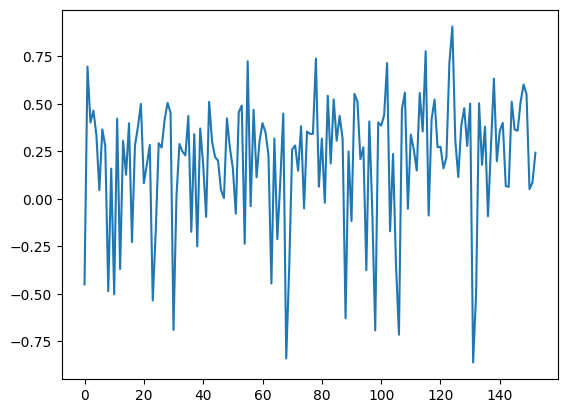

In [412]:
plt.plot(mean_of_rows.cpu().detach().numpy().tolist())
plt.show()

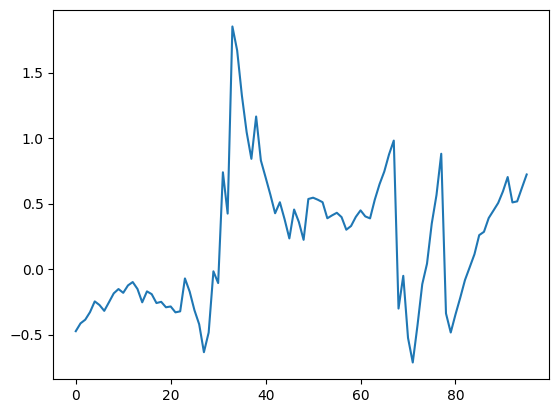

In [413]:
plt.plot(mean_of_columns.cpu().detach().numpy().tolist())
plt.show()

In [390]:
# Generate new timeseries
generator.eval()
with torch.no_grad():
    noise = torch.randn(1, noise_dim, device=device)
    avg_temp = torch.tensor([[11.5]], device=device)
    generated_timeseries = generator(noise, avg_temp)
    print(generated_timeseries)

tensor([[ 9.6123,  9.6559,  9.6326,  9.6192,  9.6005,  9.5157,  9.4088,  9.3893,
          9.3927,  9.4159,  9.3896,  9.3665,  9.3646,  9.3269,  9.2278,  9.1814,
          9.1302,  8.9806,  8.9493,  8.9517,  8.9874,  9.0214,  9.0565,  9.3634,
          9.3849,  9.4230,  9.4279,  9.4299,  9.8114, 10.3728, 10.4074, 11.4002,
         11.4823, 12.8238, 12.8389, 12.9314, 12.9683, 13.0475, 13.4350, 13.5105,
         13.6120, 13.7473, 13.7455, 14.0502, 14.1696, 14.2276, 14.5466, 14.6006,
         14.6230, 15.0109, 15.0876, 15.1542, 15.1824, 15.2046, 15.2190, 15.2198,
         15.2193, 15.2129, 15.2246, 15.2657, 15.2547, 15.1652, 15.0262, 14.9985,
         14.8897, 14.8157, 14.8202, 14.6713, 13.5142, 13.5013, 12.9506, 12.5808,
         12.5893, 12.5007, 12.4607, 12.4685, 12.4869, 12.4667, 11.4062, 11.1337,
         11.1121, 11.1544, 11.0740, 11.0100, 11.0125, 11.0322, 11.0165, 10.9723,
         10.9482, 10.9108, 10.9330, 10.9023, 10.7016, 10.6318, 10.6139, 10.6597]],
       device='cuda:0')


In [391]:
generated_timeseries.cpu().detach().numpy().mean()

11.926514

In [172]:
import matplotlib.pyplot as plt

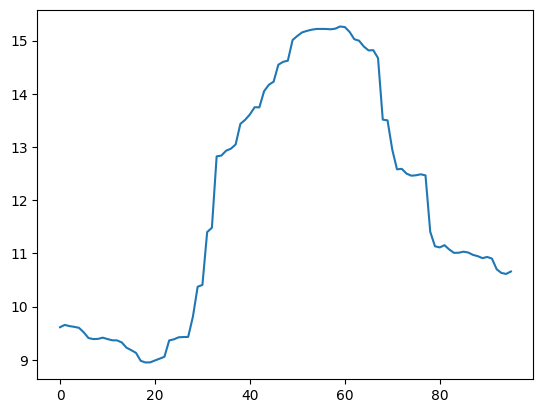

In [392]:
plt.plot(generated_timeseries.cpu().detach().numpy().tolist()[0])
plt.show()

In [388]:
all_timeseries[1,:].cpu().detach().numpy().mean()

11.541666666666666

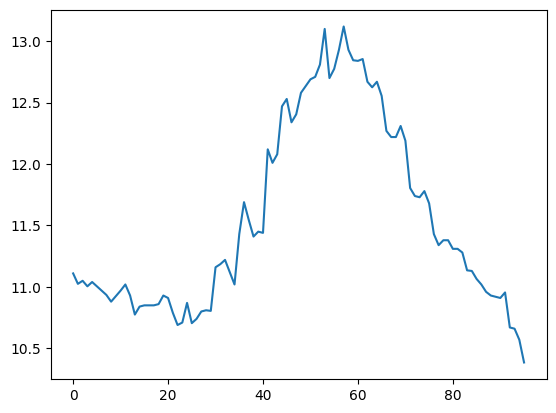

In [389]:
plt.plot(all_timeseries[1,:].cpu().detach().numpy().tolist())
plt.show()

In [414]:
torch.save(generator, 'GAN_model.pth')